Importing Libraries 

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LSTM, TimeDistributed
from tensorflow.keras.layers import Reshape
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

Declaring Path to the Excel_file ,Image_folders and Word_folder

In [44]:
excel_path = r"F:\Projects\project_10_bangla_ocr\Dataset for Bangla Text Detection and Recognition\Typing List.xlsx"
image_folder_path = r"F:\Projects\project_10_bangla_ocr\Dataset for Bangla Text Detection and Recognition\Image Folder"
text_folder_path = r"F:\Projects\project_10_bangla_ocr\Dataset for Bangla Text Detection and Recognition\Word Folder"


Loading Excel file info

In [45]:
df = pd.read_excel(excel_path, usecols="C,D", skiprows=1, names=['Image Name', 'Word File Name'])

Preprocessing function for images

In [46]:
def preprocess_image(image_path):
    """Preprocessing by resizing, blurring, and thresholding."""
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        return None
    # Resize to 1024 x 682
    img_resized = cv2.resize(image, (1024, 682))
    # Gaussian blur
    blurred = cv2.GaussianBlur(img_resized, (5, 5), 0)
    # thresholding
    thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    return thresh

Line detection function

In [48]:
def detect_lines(image):
    """Detect lines in a binary thresholded image."""
    lines = []
    in_line = False
    for row in range(image.shape[0]):
        if np.sum(image[row] == 0) > 0:  # Detect black pixels in row
            if not in_line:
                line_start = row
                in_line = True
        else:
            if in_line:
                line_end = row
                lines.append(image[line_start:line_end, :])  # Extract line
                in_line = False
    return lines

Function to load text from word file

In [49]:

def load_text_from_word_file(word_file_path):
    try:
        with open(word_file_path, 'r', encoding='utf-8') as f:
            text = f.read().strip()
    except UnicodeDecodeError:
        with open(word_file_path, 'r', encoding='ISO-8859-1') as f:
            text = f.read().strip()
    return text


Loading the images and the labels

In [50]:
images = []
labels = []

for idx, row in df.iterrows():
    img_name = row['Image Name']
    word_file_name = row['Word File Name']
    if pd.isna(img_name) or pd.isna(word_file_name):
        continue
    
    # Searching the image and word file in subfolders
    img_path = None
    word_file_path = None
    
    for subfolder in os.listdir(image_folder_path):
        potential_img_path = os.path.join(image_folder_path, subfolder, img_name)
        if os.path.isfile(potential_img_path):
            img_path = potential_img_path
            break
    
    for subfolder in os.listdir(text_folder_path):
        potential_word_path = os.path.join(text_folder_path, subfolder, word_file_name)
        if os.path.isfile(potential_word_path):
            word_file_path = potential_word_path
            break

        
    # Loading and preprocessing the images
    if img_path:
        image = preprocess_image(img_path)
        if image is not None:
            # Detect lines and process each line
            lines = detect_lines(image)
            for line in lines:
                line_resized = cv2.resize(line, (256, 32))  # Resize to fixed height
                line_normalized = line_resized / 255.0
                images.append(line_normalized)
                # Load label from word file
                if word_file_path:
                    text_label = load_text_from_word_file(word_file_path)
                    labels.append(text_label)


Converting images and labels to numpy arrays and reshaping all the images

In [51]:
images = np.array(images, dtype=np.float32)
images = np.expand_dims(images, axis=-1)  # Add channel dimension for grayscale
labels = np.array(labels)

# Encoding labels to integers
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
import pickle

# Save the LabelEncoder
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)
# Splitting dataset into training, validation, and test sets
train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels_encoded, test_size=0.2, random_state=42
)
val_images, test_images, val_labels, test_labels = train_test_split(
    test_images, test_labels, test_size=0.5, random_state=42
)

The CNN-LSTM Model Architecture

In [64]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 256, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Reshape((1, 128)),  # Reshaping for LSTM input
    LSTM(64, return_sequences=False),  # Adding LSTM layer
    Dense(len(label_encoder.classes_), activation='softmax')  # Output layer( with number of classes)
])


C:\Users\tahsi\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Compiling the model

In [65]:
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Training the model

In [ ]:
history = model.fit(
    train_images,
    train_labels,
    epochs=20,
    validation_data=(val_images, val_labels),
    batch_size=16
)

In [15]:
from tensorflow.keras.models import save_model

model.save("bangla_ocr_model.h5")
print("Model saved successfully.")


Model saved successfully.


Evaluating on the test set

In [32]:

test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"Test Accuracy: {test_accuracy}")

68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.1370 - loss: 4.1994
Test Accuracy: 0.12871746718883514


Displaying some preprocessed lines for verification

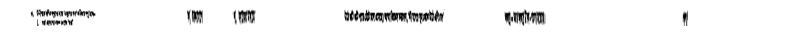

In [ ]:
def display_images(images, num_images=5):
    plt.figure(figsize=(10, 5))
    for i in range(num_images):
        if i >= len(images):
            break
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i].reshape(32, 256), cmap='gray')  # Update display dimensions
        plt.axis('off')
    plt.show()

display_images(train_images, num_images=5)

Plotting training history

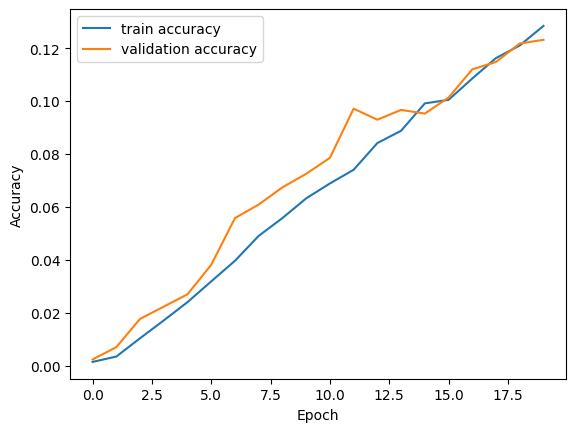

In [34]:

plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Analyzing why the model is not showing 100% accuracy by showing 
if  each line finding the correct word lines 

Loading image from: F:\Projects\project_10_bangla_ocr\Dataset for Bangla Text Detection and Recognition\Image Folder\Adar_Kora_Alo_Page161_to_Page176\Adar_Kora_Alo_Page161_to_Page176_Page_01-9oVL1f.jpg
Detecting lines in the image...
Total Detected Lines: 16
Extracting text lines from Word file: F:\Projects\project_10_bangla_ocr\Dataset for Bangla Text Detection and Recognition\Word Folder\Adar_Kora_Alo_Page161_to_Page176\Adar_Kora_Alo_Page161_to_Page176_Page_01.docx
Total Text Lines from Word File: 30
Verifying lines for image: F:\Projects\project_10_bangla_ocr\Dataset for Bangla Text Detection and Recognition\Image Folder\Adar_Kora_Alo_Page161_to_Page176\Adar_Kora_Alo_Page161_to_Page176_Page_01-9oVL1f.jpg and Word file: F:\Projects\project_10_bangla_ocr\Dataset for Bangla Text Detection and Recognition\Word Folder\Adar_Kora_Alo_Page161_to_Page176\Adar_Kora_Alo_Page161_to_Page176_Page_01.docx


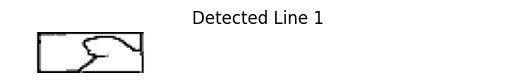

Expected Text Line 1: আমার হাতে এই মুহূর্তে যে কাগজটি আছে খাঁটি বাংলায় তার নাম


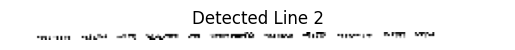

Expected Text Line 2: তালাকপত্র ।


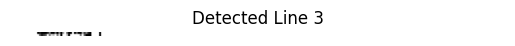

Expected Text Line 3: বুয়ার ভাষায় ডাইফুস লেটার ।


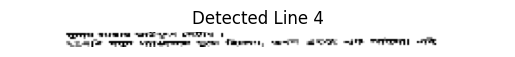

Expected Text Line 4: আপনি যহন ব্যাডরুমে ঘুমে ছিলেন, তখন একটা লুক আইস্যা এই


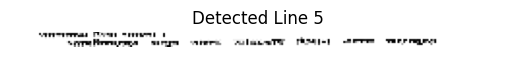

Expected Text Line 5: প্যাপারডা দিয়া গ্যালো ।


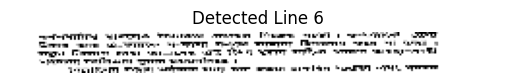

Expected Text Line 6: ময়মনিসংহের মানুষ বাংলা সাহিত্যের বিশাল একটা অংশজুড়ে


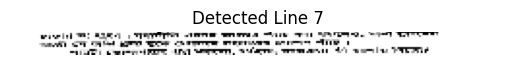

Expected Text Line 7: দখলদারিত্ব রাখলেও উচ্চারণে বেদখল নিজের মতো। ও-কারকে হ্রস্য


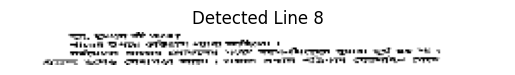

Expected Text Line 8: উকার আর এ-কারকে য-ফালা বলতে সামান্য দ্বিধাবোধ করে না তারা ।


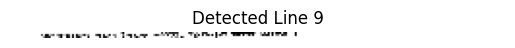

Expected Text Line 9: নতুন নিয়োগ দেয়া আমাদের এই ঠিকা বুয়ার বাড়িও ঢাকায় অবস্থানকারী


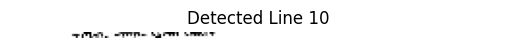

Expected Text Line 10: শতকরা আশিভাগ বুয়ার ময়মনসিংহ ।


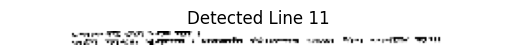

Expected Text Line 11: নিয়োগের কারণ নবীনার সদ্য শুরু হওয়া চাকরির ব্যস্ততা এবং ঘনঘন


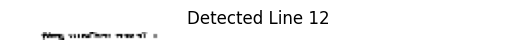

Expected Text Line 12: ঢাকায় না থাকা । যথারীতি বাসার কাজের প্যাচ কম বুঝলেও, অন্য বুয়াদের


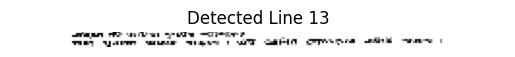

Expected Text Line 13: মতো সে অতি দ্রুত বুঝে ফেলেছে সংসারের গোপন প্যাঁচ ।


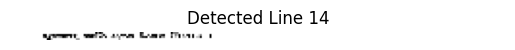

Expected Text Line 14: খামটা তোলামাত্রই প্রশ্ন করলো, ভাইয়া, কাগুজডা কী আপায় দিচ্ছে?


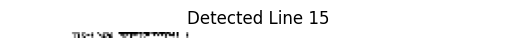

Expected Text Line 15: বুঝলে কী করে ?


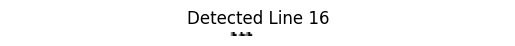

Expected Text Line 16: হ্যাঁ,


NameError: name 'matched_lines' is not defined

In [ ]:
import docx
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Preprocessing function for images
def preprocess_image(image_path):
    """Resize, blur, and threshold an image for text line detection."""
    print(f"Loading image from: {image_path}")
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print("Failed to load the image.")
        return None
    img_resized = cv2.resize(image, (1024, 682))  # Resize to a standard size
    blurred = cv2.GaussianBlur(img_resized, (5, 5), 0)  # Apply Gaussian blur
    thresh = cv2.adaptiveThreshold(
        blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2
    )
    return thresh

# Line detection function
def detect_lines(image):
    """Detect text lines in a preprocessed image."""
    print("Detecting lines in the image...")
    lines = []
    in_line = False
    for row in range(image.shape[0]):
        if np.sum(image[row] == 0) > 0:  # Detect black pixels in the row
            if not in_line:
                line_start = row
                in_line = True
        else:
            if in_line:
                line_end = row
                lines.append(image[line_start:line_end, :])  # Extract the line
                in_line = False
    print(f"Total Detected Lines: {len(lines)}")
    return lines

# Extract text lines from a Word file
def extract_text_lines_from_word(word_file_path):
    """Extract text lines from a .docx file."""
    print(f"Extracting text lines from Word file: {word_file_path}")
    doc = docx.Document(word_file_path)
    text_lines = [paragraph.text.strip() for paragraph in doc.paragraphs if paragraph.text.strip()]
    print(f"Total Text Lines from Word File: {len(text_lines)}")
    return text_lines

# Verify image lines against text from a Word file
def verify_image_text_lines_single(image_path, word_file_path):
    """Detect and display lines from a single image with corresponding text lines from a single Word file."""
    # Preprocess the image and detect lines
    image = preprocess_image(image_path)
    if image is None:
        print(f"Could not load image at {image_path}")
        return
    
    lines = detect_lines(image)
    if not lines:
        print("No lines detected in the image.")
        return
    
    # Extract text lines from the Word file
    text_lines = extract_text_lines_from_word(word_file_path)
    if not text_lines:
        print("No text lines found in the Word file.")
        return
    
    # Display each detected line with the corresponding text from the Word file
    print(f"Verifying lines for image: {image_path} and Word file: {word_file_path}")
    for i, line_img in enumerate(lines):
        # Resize line for display consistency
        height, width = line_img.shape
        aspect_ratio = width / height
        new_width = 256
        new_height = int(new_width / aspect_ratio)
        line_resized = cv2.resize(line_img, (new_width, new_height))
        
        # Display the line image
        plt.imshow(line_resized, cmap='gray')
        plt.title(f"Detected Line {i + 1}")
        plt.axis('off')
        plt.show()
        
        # Display corresponding text if it exists
        if i < len(text_lines):
            print(f"Expected Text Line {i + 1}: {text_lines[i]}")
        else:
            print(f"Detected Line {i + 1}: No matching text found in Word file.")


# Paths
image_path = r"F:\Projects\project_10_bangla_ocr\Dataset for Bangla Text Detection and Recognition\Image Folder\Adar_Kora_Alo_Page161_to_Page176\Adar_Kora_Alo_Page161_to_Page176_Page_01-9oVL1f.jpg"
word_file_path = r"F:\Projects\project_10_bangla_ocr\Dataset for Bangla Text Detection and Recognition\Word Folder\Adar_Kora_Alo_Page161_to_Page176\Adar_Kora_Alo_Page161_to_Page176_Page_01.docx"

# Run the verification
verify_image_text_lines_single(image_path, word_file_path)


In [ ]:
import os
import torchaudio
import pandas as pd

def preprocess_dataset(data_path, audio_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(os.path.join(output_dir, "wavs"), exist_ok=True)

    # Read dataset
    data = pd.read_csv(data_path, sep='\t', names=['filename', 'text'])
    metadata = []

    for index, row in data.iterrows():
        audio_path = os.path.join(audio_dir, row['filename'] + ".wav")

        # Load and normalize audio
        waveform, sample_rate = torchaudio.load(audio_path)
        torchaudio.save(
            os.path.join(output_dir, "wavs", f"{row['filename']}.wav"),
            waveform, sample_rate
        )

        # Prepare metadata
        metadata.append(f"{row['filename']}|{row['text']}")

    # Save metadata
    with open(os.path.join(output_dir, "metadata.csv"), 'w', encoding='utf-8') as f:
        f.write("\n".join(metadata))
    print("Dataset preprocessing complete!")

# Process dataset
preprocess_dataset(
    data_path="F:/Projects/project_10_bangla_ocr/bn_bd/line_index.tsv",
    audio_dir="F:/Projects/project_10_bangla_ocr/bn_bd/wavs",
    output_dir="./processed_dataset_bn_bd"
)


Dataset Preparation for TTS

In [12]:
import os

def prepare_metadata(metadata_path, output_dir):
    # Create metadata file
    metadata_output_path = os.path.join(output_dir, "metadata.csv")
    with open(metadata_path, "r", encoding="utf-8") as f:
        lines = f.readlines()

    data = []
    for line in lines:
        parts = line.strip().split("|")
        if len(parts) == 2:
            wav_file = parts[0] + ".wav"  # Add .wav extension
            text = parts[1]              # Extract text
            data.append(f"{wav_file}|{text}")  # Format as "audio_file|text"

    # Write processed metadata
    with open(metadata_output_path, "w", encoding="utf-8") as f:
        f.write("\n".join(data))
    print("Metadata prepared!")

# Run the function
prepare_metadata(
    metadata_path="F:/Projects/project_10_bangla_ocr/bn_bd/line_index.tsv",
    output_dir="F:/Projects/project_10_bangla_ocr/processed_dataset_bn_bd"
)


Metadata prepared!


In [16]:
import os
import pandas as pd
import torchaudio
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import warnings
import torch.nn.functional as F

# 1. Load and Process Dataset
class BanglaTTSDataset(Dataset):
    def __init__(self, data_path, audio_dir):
        self.data = pd.read_csv(data_path, sep='\t')  # Assuming tab-separated values
        self.audio_dir = audio_dir

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Ensure the file extension is correct
        filename = self.data.iloc[idx, 0]
        if not filename.endswith('.wav'):
            filename += '.wav'
        
        audio_path = os.path.join(self.audio_dir, filename)
        
        # Check if the file exists
        if not os.path.exists(audio_path):
            warnings.warn(f"File {audio_path} does not exist. Skipping.")
            return None, None
        
        try:
            waveform, sample_rate = torchaudio.load(audio_path)
            # Downsample the waveform to reduce memory usage
            waveform = torchaudio.functional.resample(waveform, sample_rate, 8000)  # Resample to 8 kHz
            text = self.data.iloc[idx, 1]
            return waveform, text
        except Exception as e:
            warnings.warn(f"Error loading {audio_path}: {e}. Skipping.")
            return None, None

# 2. Custom Collate Function
def collate_fn(batch):
    # Filter out None values
    batch = [item for item in batch if item[0] is not None and item[1] is not None]
    
    # Separate waveforms and texts
    waveforms, texts = zip(*batch)
    
    # Pad waveforms to the maximum length in the batch
    waveform_lengths = [waveform.shape[1] for waveform in waveforms]
    max_length = max(waveform_lengths)
    
    padded_waveforms = []
    for waveform in waveforms:
        # Pad the waveform to the max length
        padding = max_length - waveform.shape[1]
        padded_waveform = F.pad(waveform, (0, padding), "constant", 0)
        padded_waveforms.append(padded_waveform)
    
    # Stack padded waveforms into a single tensor
    padded_waveforms = torch.stack(padded_waveforms, dim=0)
    
    return padded_waveforms, texts

# 3. Load the dataset for both locales
DATASET_DIR_BN_BD = r"F:\Projects\project_10_bangla_ocr\bn_bd"
DATASET_DIR_BN_IN = r"F:\Projects\project_10_bangla_ocr\bn_in"

TRAIN_TSV_BN_BD = os.path.join(DATASET_DIR_BN_BD, 'line_index.tsv')
AUDIO_DIR_BN_BD = os.path.join(DATASET_DIR_BN_BD, 'wavs')

TRAIN_TSV_BN_IN = os.path.join(DATASET_DIR_BN_IN, 'line_index.tsv')
AUDIO_DIR_BN_IN = os.path.join(DATASET_DIR_BN_IN, 'wavs')

train_dataset_bd = BanglaTTSDataset(TRAIN_TSV_BN_BD, AUDIO_DIR_BN_BD)
train_dataset_in = BanglaTTSDataset(TRAIN_TSV_BN_IN, AUDIO_DIR_BN_IN)

# Combine the datasets manually to ensure correct concatenation
combined_dataset = torch.utils.data.ConcatDataset([train_dataset_bd, train_dataset_in])

# Filter out None values from the dataset
class FilteredDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.valid_indices = [i for i in range(len(dataset)) if dataset[i][0] is not None]

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        return self.dataset[self.valid_indices[idx]]

filtered_dataset = FilteredDataset(combined_dataset)
train_loader = DataLoader(filtered_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)  # Reduced batch size

# 4. Define a Simple TTS Model
class SimpleTTSModel(nn.Module):
    def __init__(self):
        super(SimpleTTSModel, self).__init__()
        # Add a convolutional layer to preprocess the input
        self.preprocess = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=80, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        self.encoder = nn.LSTM(input_size=80, hidden_size=64, num_layers=1, batch_first=True)  # Reduced hidden size and layers
        self.decoder = nn.Linear(64, 1)  # Output a single feature (same as input)
        self.upsample = nn.Upsample(scale_factor=2, mode='linear')  # Upsample to match target sequence length

    def forward(self, x):
        # Reshape the input tensor
        x = x.squeeze(1)  # Remove the channel dimension
        x = x.unsqueeze(1)  # Add a channel dimension for Conv1d
        x = self.preprocess(x)  # Apply the preprocessing layer
        x = x.transpose(1, 2)  # Reshape to (batch_size, sequence_length, input_size)
        x, _ = self.encoder(x)
        x = self.decoder(x)  # Decode to (batch_size, sequence_length, 1)
        x = x.transpose(1, 2)  # Reshape to (batch_size, 1, sequence_length)
        x = self.upsample(x)  # Upsample to match target sequence length
        
        # Trim or pad the output to match the target sequence length
        target_length = x.size(2)
        if target_length != x.size(2):
            x = F.pad(x, (0, target_length - x.size(2)), "constant", 0)
        
        return x

# Initialize the model
model = SimpleTTSModel()

# 5. Training Configuration
train_config = {
    "batch_size": 4,  # Reduced batch size
    "learning_rate": 1e-4,
    "epochs": 50,
    "output_path": "./output_model"
}

# Defining loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=train_config['learning_rate'])

# 6. Start Training 
for epoch in range(train_config['epochs']):
    model.train()
    for waveforms, texts in train_loader:
        # Forward pass
        outputs = model(waveforms)
        
        # Ensuring the output and target sequence lengths match
        target_length = waveforms.size(2)
        if outputs.size(2) != target_length:
            outputs = F.pad(outputs, (0, target_length - outputs.size(2)), "constant", 0)
        
        loss = criterion(outputs, waveforms)  # Example loss calculation

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{train_config['epochs']}] completed!")

# 7. Save Model
os.makedirs(train_config['output_path'], exist_ok=True)
torch.save(model.state_dict(), os.path.join(train_config['output_path'], "bangla_tts_model.pth"))

print("Training Complete!")

Epoch [1/50] completed!
Epoch [2/50] completed!
Epoch [3/50] completed!
Epoch [4/50] completed!
Epoch [5/50] completed!
Epoch [6/50] completed!
Epoch [7/50] completed!
Epoch [8/50] completed!
Epoch [9/50] completed!
Epoch [10/50] completed!
Epoch [11/50] completed!
Epoch [12/50] completed!
Epoch [13/50] completed!
Epoch [14/50] completed!
Epoch [15/50] completed!
Epoch [16/50] completed!
Epoch [17/50] completed!
Epoch [18/50] completed!
Epoch [19/50] completed!
Epoch [20/50] completed!
Epoch [21/50] completed!
Epoch [22/50] completed!
Epoch [23/50] completed!
Epoch [24/50] completed!
Epoch [25/50] completed!
Epoch [26/50] completed!
Epoch [27/50] completed!
Epoch [28/50] completed!
Epoch [29/50] completed!
Epoch [30/50] completed!
Epoch [31/50] completed!
Epoch [32/50] completed!
Epoch [33/50] completed!
Epoch [34/50] completed!
Epoch [35/50] completed!
Epoch [36/50] completed!
Epoch [37/50] completed!
Epoch [38/50] completed!
Epoch [39/50] completed!
Epoch [40/50] completed!
Epoch [41